In [572]:
from __future__ import print_function
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import random
import itertools
from scipy.stats import norm
from datetime import datetime
import requests
from io import BytesIO
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import json
from pprint import pprint
%pylab inline
from statsmodels.tsa import stattools
from pandas.tools.plotting import autocorrelation_plot

Populating the interactive namespace from numpy and matplotlib


In [573]:
data = pd.read_csv("uber_lyft_March.csv")

In [574]:
data.head()

,date_time,uber_distance,uber_duration,uber_estimate,uber_high_estimate,uber_low_estimate,main_temp,weather,uber_price_per_second,lyft_distance,lyft_duration,lyft_max_estimate,lyft_min_estimate,lyft_estimate,lyft_price_per_second,average_duration
0,3/1/18 0:00,1.73,360,7.5,9,6,46.69,Rain,0.019380,1.76,414,3.40,3.40,3.40,0.008786,387.0
1,3/1/18 0:01,1.90,480,5.5,7,4,46.69,Rain,0.010816,1.79,537,3.53,3.53,3.53,0.006942,508.5
2,3/1/18 0:02,2.26,420,7.0,9,5,46.56,Rain,0.015436,2.20,487,3.85,3.85,3.85,0.008490,453.5
3,3/1/18 0:03,1.63,360,7.5,9,6,46.56,Rain,0.018029,1.70,472,3.46,3.46,3.46,0.008317,416.0
4,3/1/18 0:04,2.17,480,9.5,11,8,46.56,Rain,0.018393,2.21,553,3.47,3.47,3.47,0.006718,516.5


In [575]:
data.columns

Index(['date_time', 'uber_distance', 'uber_duration', 'uber_estimate',
       'uber_high_estimate', 'uber_low_estimate', 'main_temp', 'weather',
       'uber_price_per_second', 'lyft_distance', 'lyft_duration',
       'lyft_max_estimate', 'lyft_min_estimate', 'lyft_estimate',
       'lyft_price_per_second', 'average_duration'],
      dtype='object')

In [576]:
data = data.set_index(pd.DatetimeIndex(data['date_time']))

In [577]:
data.index

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 00:01:00',
               '2018-03-01 00:02:00', '2018-03-01 00:03:00',
               '2018-03-01 00:04:00', '2018-03-01 00:06:00',
               '2018-03-01 00:07:00', '2018-03-01 00:08:00',
               '2018-03-01 00:09:00', '2018-03-01 00:10:00',
               ...
               '2018-03-31 23:50:00', '2018-03-31 23:51:00',
               '2018-03-31 23:52:00', '2018-03-31 23:53:00',
               '2018-03-31 23:54:00', '2018-03-31 23:55:00',
               '2018-03-31 23:56:00', '2018-03-31 23:57:00',
               '2018-03-31 23:58:00', '2018-03-31 23:59:00'],
              dtype='datetime64[ns]', name='date_time', length=44434, freq=None)

In [578]:
y_uber=data['uber_price_per_second'].resample('2H').mean()

We will use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest. Let's begin by generating the various combination of parameters that we wish to assess:

Why is the stability of time series so important? 

Most time series models are built on the assumption that it is stable. I

ntuitively, we can think that if a time series produces specific behavior over time, there is a high probability that it will behave the same in the future. 
At the same time, the theory derived from stable sequences is more mature and it is easier to compare with non-stable sequences.

The criteria for determining the stability are very strict. However, if the time series produces constant statistical characteristics over time, we can assume that the sequence is stable based on practical purposes. as follows:

#### Constant average
#### Constant variance
#### Self-covariance that does not change over time

为什么时间序列的稳定性这么重要？大部分时间序列模型是在假设它是稳定的前提下建立的。直观地说，我们可以这样认为，如果一个时间序列随着时间产生特定的行为，就有很高的可能性认为它在未来的行为是一样的。同时，根据稳定序列得出的理论是更加成熟的， 也是更容易实现与非稳定序列的比较。

稳定性的确定标准是非常严格的。但是，如果时间序列随着时间产生恒定的统计特征，根据实际目的我们可以假设该序列是稳定的。如下：

恒定的平均数
恒定的方差
不随时间变化的自协方差

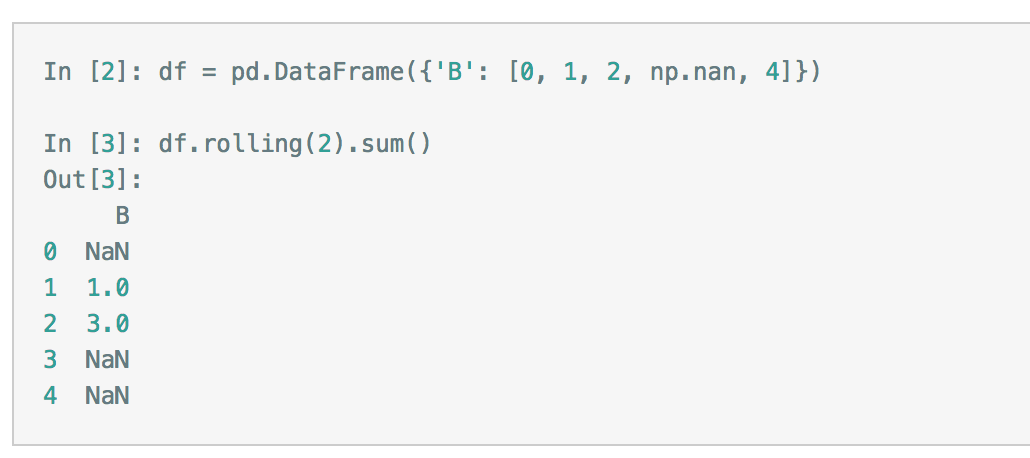

In [579]:
from statsmodels.tsa.stattools import adfuller

#Define a function to check the stationary of the timeseries
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #pandas.rolling_count(arg, window, freq=None, center=False, how=None)
    #The number of window means we calculate 12 numbers at each time 
    #We reample the data frequecy as 2 hour, so we select one day: 12*2 = 24 hours, set window = 12
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics of Orginal, mean and std:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

adfuller(timeseries, autolag='AIC')
x : array_like, 1d -- data series

if ‘AIC’ (default) or ‘BIC’, then the number of lags is chosen to minimize the corresponding information criterion

##### With the autolag='AIC' the function will return the output of the test statistic for a model with the best possible AIC score.

#### DF Test:
The unit root test refers to the presence of a unit root in the test sequence because the existence of a unit root is a non-stationary time series. The unit root refers to the process of the unit root. It can be proved that the unit root process in the sequence is not stable and it will cause a spurious regression in the regression analysis.

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.
<br>
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

单位根检验是指检验序列中是否存在单位根，因为存在单位根就是非平稳时间序列了。单位根就是指单位根过程，可以证明，序列中存在单位根过程就不平稳，会使回归分析中存在伪回归。
在离散时间序列模型中，如自回归移动平均（AR-MA）过程，模型的自回归部分的‘单位根’表明序列是不平稳的，即随时间的推进，它并没有回到给定值的趋势（长期均值）。

#### pandas.Series(data=None, index=None, dtype=None, name=None, copy=False, fastpath=False)

data : array-like, dict, or scalar value
Contains data stored in Series

index : array-like or Index (1d)

Values must be hashable and have the same length as data. Non-unique index values are allowed. Will default to RangeIndex(len(data)) if not provided. If both a dict and index sequence are used, the index will override the keys found in the dict.

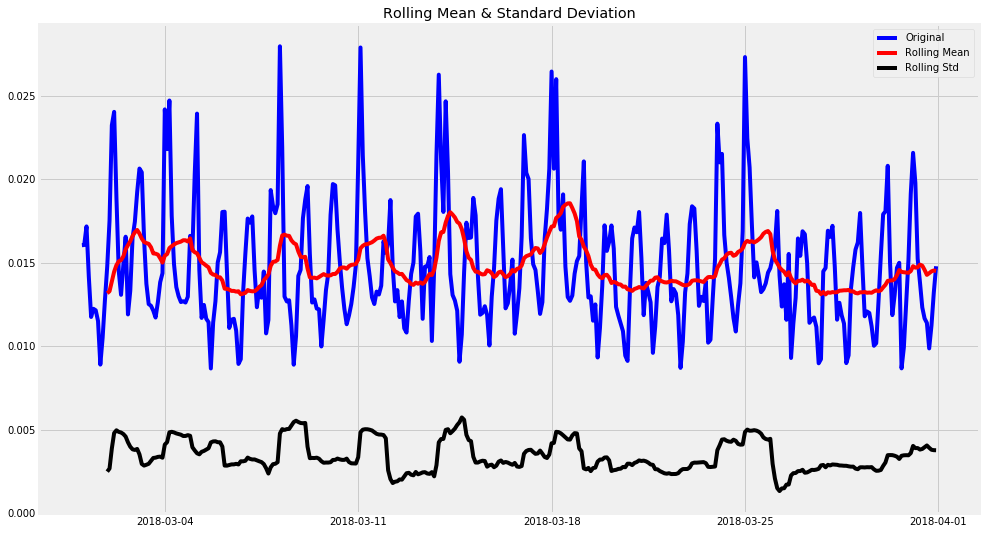

Results of Dickey-Fuller Test:
Test Statistic                  -4.938296
p-value                          0.000029
#Lags Used                      17.000000
Number of Observations Used    354.000000
Critical Value (1%)             -3.448958
Critical Value (5%)             -2.869739
Critical Value (10%)            -2.571138
dtype: float64


In [580]:
plt.rcParams['figure.figsize'] = (15, 9)
test_stationarity(y_uber)

#### p-value < 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

There are three distinct integers <b>(p, d, q)</b> that are used to parametrize ARIMA models. 
Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). 
Together these three parameters account for seasonality, trend, and noise in datasets:

<b>p</b> is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model.
Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.


<b>d</b> is the integrated part of the model.
This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series.

Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.


<b>q</b> is the moving average part of the model. 
This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.


p:（将过去的数值应用在模型中） （比如如果前几天都很暖和，我们可以预测明天也很暖和）
<br>
d:（将difference的数值应用在模型中，比如过去的数值减去现在的数值）（比如如果前三天的温度变化比较小，我们可以预测明天的气温变化也很小）
<br>
q:（这使我们可以将我们模型的误差设置为过去在以前时间点观察到的误差值的线性组合。）

自回归函数（AR）的条件（p）：AR条件仅仅是因变量的滞后。如：如果P等于5，那么预测x（t）将是x（t-1）。。。（t-5）。
<br>
移动平均数(MA)的条件(q):MA条件是预测方程的滞后预测错误。如：如果q等于5，预测x（t）将是e（t-1）。。。e(t-5),e(i)是移动平均叔在第ith个瞬间和实际值的差值。
<br>
差分（d）：有非季节性的差值，即这种情况下我们采用一阶差分。所以传递变量，令d=0或者传递原始变量，令d=1。两种方法得到的结果一样。

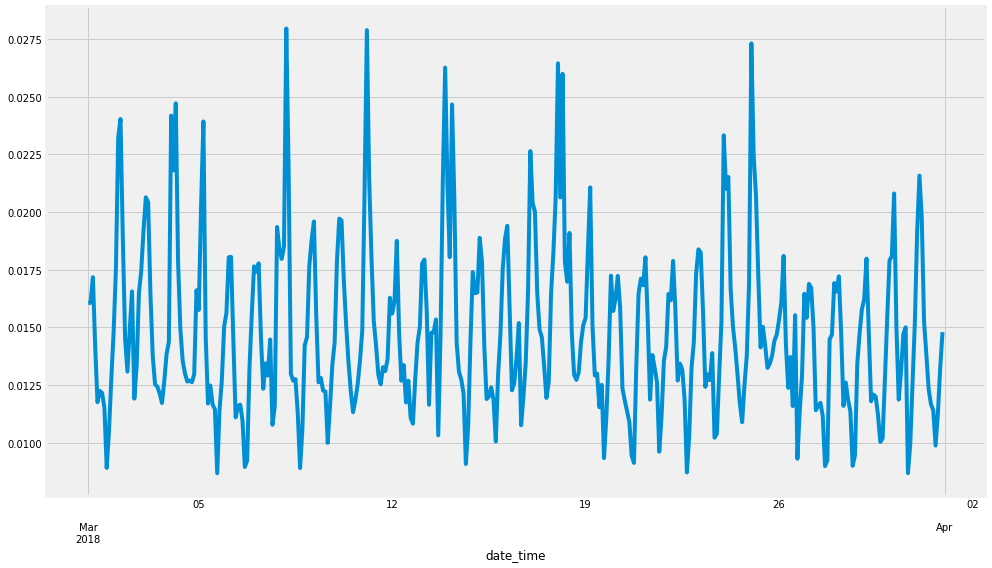

In [581]:
plt.rcParams['figure.figsize'] = (15, 9)
y_uber.plot()

This plot shows that we don't have much trend, but we have some seasonal-like impact
<br>
Let's try to reduce this impact:

Let us talk about two ways to eliminate trends and seasonality.

#### Difference - using a difference in a specific time difference
#### Decomposition - Establish models for trends and seasonality and remove them from the model.

之前讨论来了简单的趋势减少技术不能在所有情况下使用，特别是在高季节性情况下。让我们谈论一下两种消除趋势和季节性的方法。

差分–采用一个特定时间差的差值
分解——建立有关趋势和季节性的模型和从模型中删除它们。

Let's try which one is better for our data:

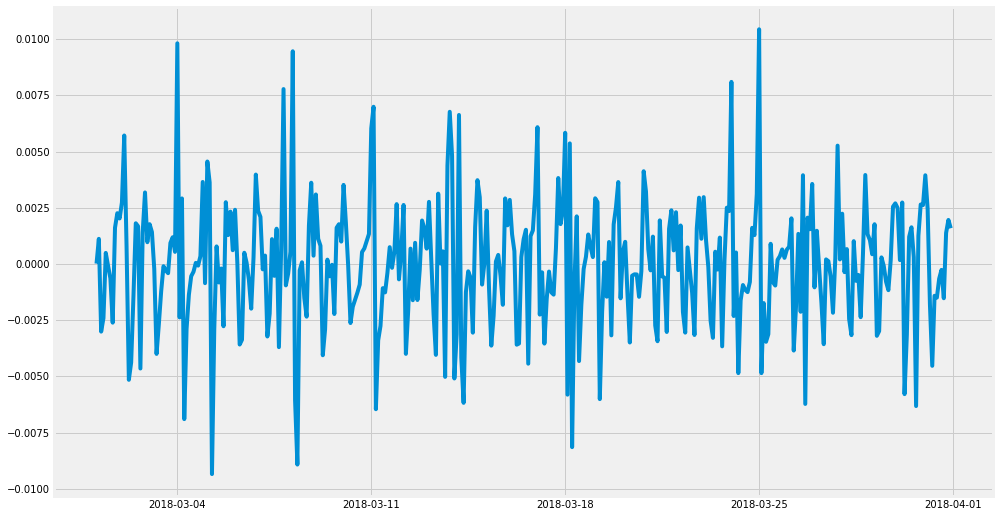

In [582]:
#Try shift 1
uber_diff = y_uber - y_uber.shift()
plt.plot(uber_diff)

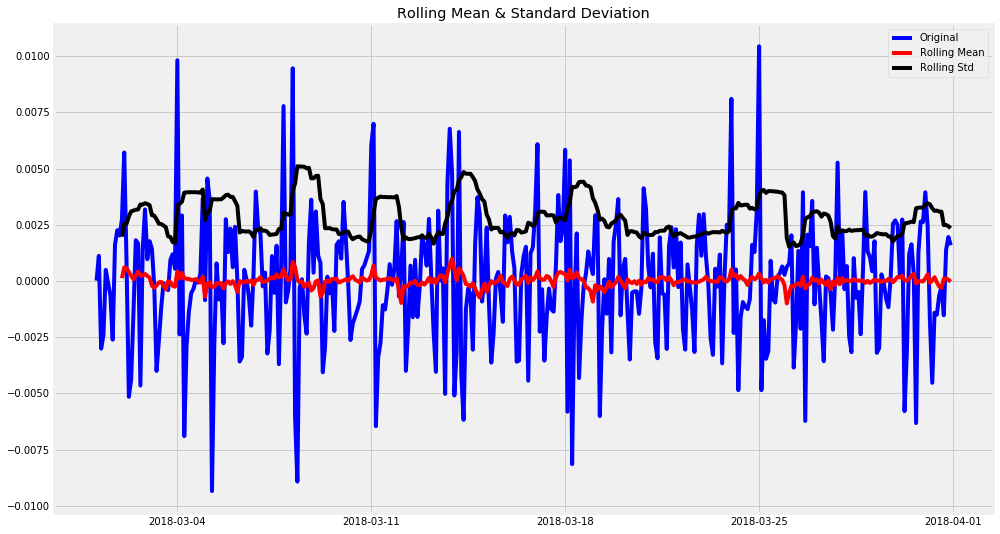

Results of Dickey-Fuller Test:
Test Statistic                -5.846154e+00
p-value                        3.679580e-07
#Lags Used                     1.700000e+01
Number of Observations Used    3.530000e+02
Critical Value (1%)           -3.449011e+00
Critical Value (5%)           -2.869763e+00
Critical Value (10%)          -2.571151e+00
dtype: float64


In [583]:
#Then test the stationary again:
uber_diff.dropna(inplace=True)
test_stationarity(uber_diff)

We can see the P value reduced a lot and also
<br>
the rolling mean is much more close to 0
<br>
the rolling std reduce from 0.05 to 0.025
<br>
This proves the shift mehond works well
<br>
<br>

Now, Let's try shift 2 and test again and see which one is better:

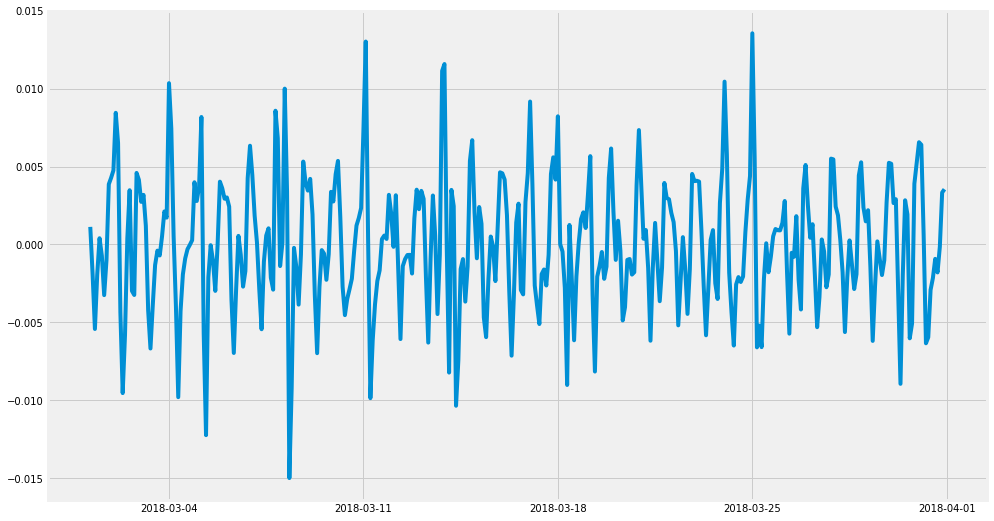

In [584]:
#Try shift 2
uber_diff_2 = y_uber - y_uber.shift(2)
plt.plot(uber_diff_2)

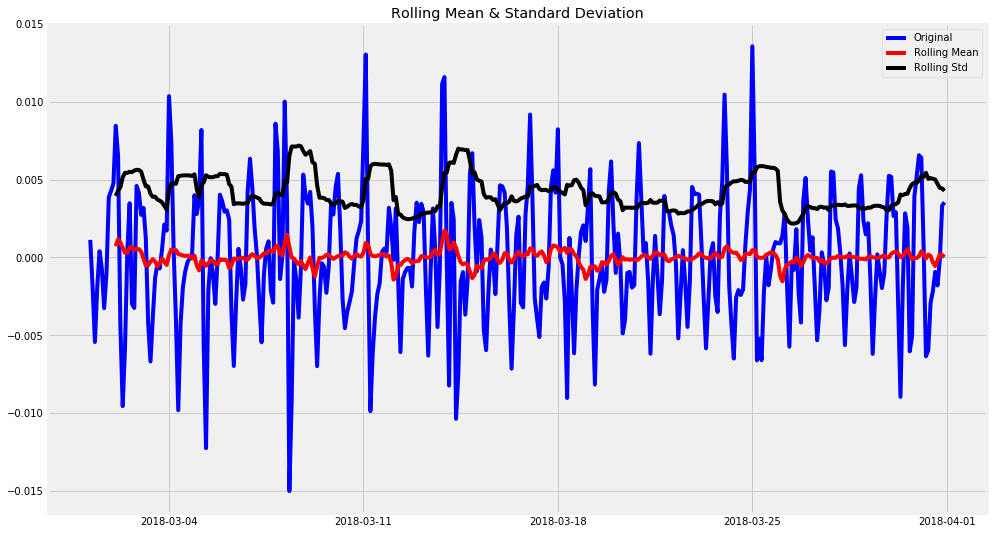

Results of Dickey-Fuller Test:
Test Statistic                -6.275844e+00
p-value                        3.902596e-08
#Lags Used                     1.200000e+01
Number of Observations Used    3.570000e+02
Critical Value (1%)           -3.448801e+00
Critical Value (5%)           -2.869670e+00
Critical Value (10%)          -2.571101e+00
dtype: float64


In [585]:
#Then test the stationary again:
uber_diff_2.dropna(inplace=True)
test_stationarity(uber_diff_2)

Compare 2 results, we can conclude that shift 1 is better than shift 2
<br>
So we will choose shift 1

Then let's try another methond "Decomposition"

### Decomposition

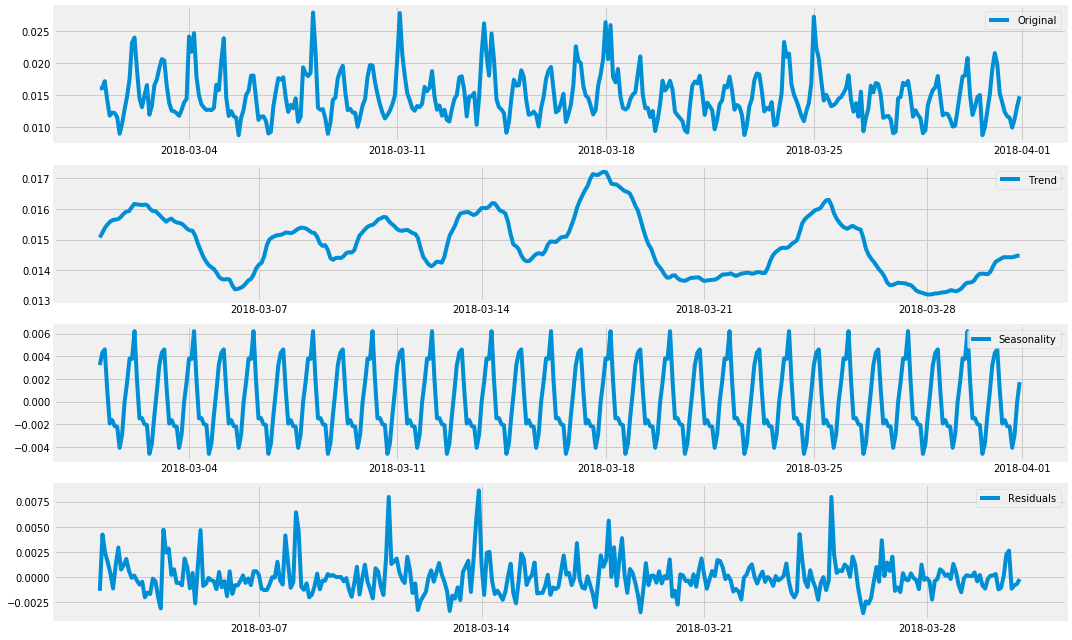

In [586]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y_uber)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(y_uber, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

ubplot(nrows, ncols, index, **kwargs)

In the current figure, create and return an Axes, at position index of a (virtual) grid of nrows by ncols axes. Indexes go from 1 to nrows * ncols, incrementing in row-major order.

These are subplot grid parameters encoded as a single integer. 
For example, "111" means "1x1 grid, first subplot" and "234" means "2x3 grid, 4th subplot".

#### This is Automatic Time Series Decomposition
<br>
The seasonal_decompose() function returns a result object. The result object contains arrays to access four pieces of data from the decomposition.
<br>
This plot shows decomposition of series into trend, seasonal, and residual components.
<br>
<br>
Here we can see the trend, seasonal separation from the data, we can build a residual model, let us check the stability of the residual:

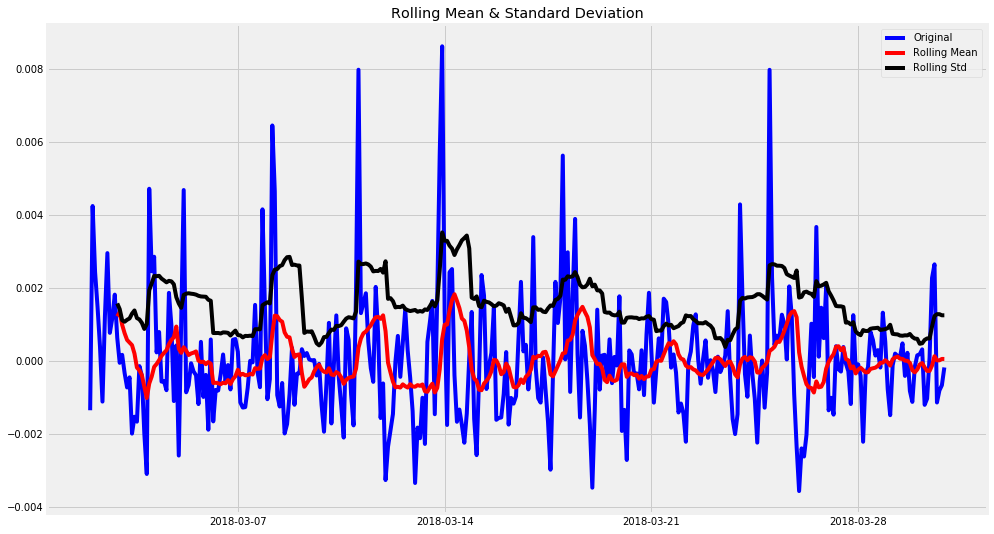

Results of Dickey-Fuller Test:
Test Statistic                -8.671086e+00
p-value                        4.544458e-14
#Lags Used                     9.000000e+00
Number of Observations Used    3.380000e+02
Critical Value (1%)           -3.449846e+00
Critical Value (5%)           -2.870129e+00
Critical Value (10%)          -2.571346e+00
dtype: float64


In [587]:
uber_decompose = residual
uber_decompose.dropna(inplace=True)
test_stationarity(uber_decompose)

Now we can see P value is very small and the rolling std even reduces to 0.002
<br>
However, the rolling mean is not stable
<br>
<br>
#### Now, We will choose difference Let's apply to the MA model 


Fisrt, Let's try to define the numer of p,d,q using first method: 
#### Difference

In [588]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

自相关函数（ACF）：这是时间序列和它自身滞后版本之间的相关性的测试。比如在自相关函数可以比较时间的瞬间‘t1’…’t2’以及序列的瞬间‘t1-5’…’t2-5’ (t1-5和t2 是结束点)。
<br>
部分自相关函数(PACF):这是时间序列和它自身滞后版本之间的相关性测试，但是是在预测（已经通过比较干预得到解释）的变量后。如：滞后值为5，它将检查相关性，但是会删除从滞后值1到4得到的结果。

Autocorrelation function (ACF): This is a test of the correlation between the time series and its own lagging version. For example, at the instant when the autocorrelation function can compare time, 't1'...'t2' and the moment of the sequence 't1-5'...'t2-5' (t1-5 and t2 are end points).



Partial autocorrelation function (PACF): This is a correlation test between the time series and its own lagging version, but after predicting the variable (which has been explained by the comparison intervention). For example, if the lag value is 5, it will check the correlation, but it will remove the results from the lag values 1 to 4.
<br>
PACF (partial autocorrelation function) is essentially the autocorrelation of a signal with itself at different points in time, with linear dependency with that signal at shorter lags removed, as a function of lag between points of time. 

In [589]:
lag_acf_shift = acf(uber_diff, nlags=20)
lag_pacf_shift = pacf(uber_diff, nlags=20, method='ols')

matplotlib.pyplot.axhline(y=0, xmin=0, xmax=1, hold=None, **kwargs)
Add a horizontal line across the axis.

y : scalar, optional, default: 0
y position in data coordinates of the horizontal line.

xmin : scalar, optional, default: 0
Should be between 0 and 1, 0 being the far left of the plot, 1 the far right of the plot.

xmax : scalar, optional, default: 1
Should be between 0 and 1, 0 being the far left of the plot, 1 the far right of the plot.

Text(0.5,1,'Autocorrelation Function')

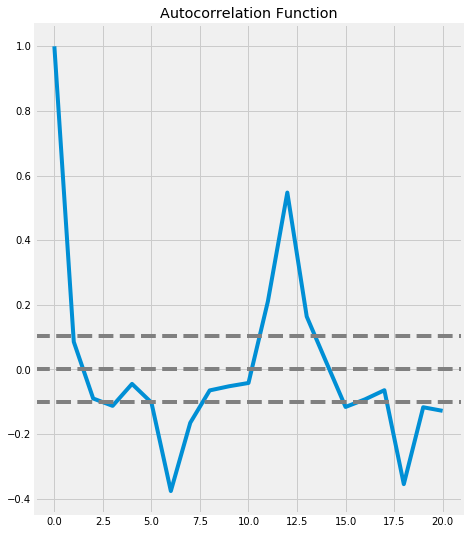

In [590]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf_shift)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(uber_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(uber_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

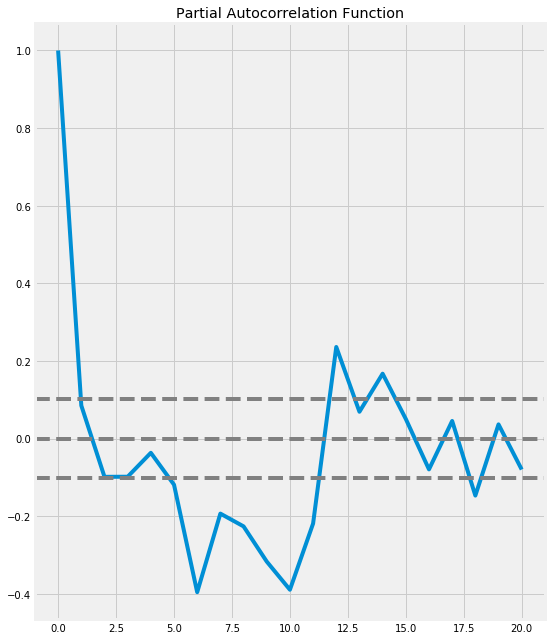

In [591]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf_shift)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(uber_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(uber_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

The upper confidence interval for the first truncation of the p-part autocorrelation function table is the lag value. If you look closely, the value is p=2.

The upper bound confidence interval for the first truncation of the q- autocorrelation function table is the lag value. If you look closely, the value is q=2.

Now, apply to 
#### MA Model

In [592]:
from statsmodels.tsa.arima_model import ARIMA

A nonseasonal ARIMA model is classified as an "ARIMA(p,d,q)" model, where:

p is the number of autoregressive terms,
<br>
d is the number of nonseasonal differences needed for stationarity, and
<br>
q is the number of lagged forecast errors in the prediction equation.

results_ARIMA = model.fit(disp=-1)  
<br>
Fits ARIMA(p,d,q) model by exact maximum likelihood via Kalman filter.
<br>
disp : int, optional
<br>
disp < 0 means no output in this case.

RSS here refers to the residual

try 
#### Combination model

Text(0.5,1,'RSS: 0.0021')

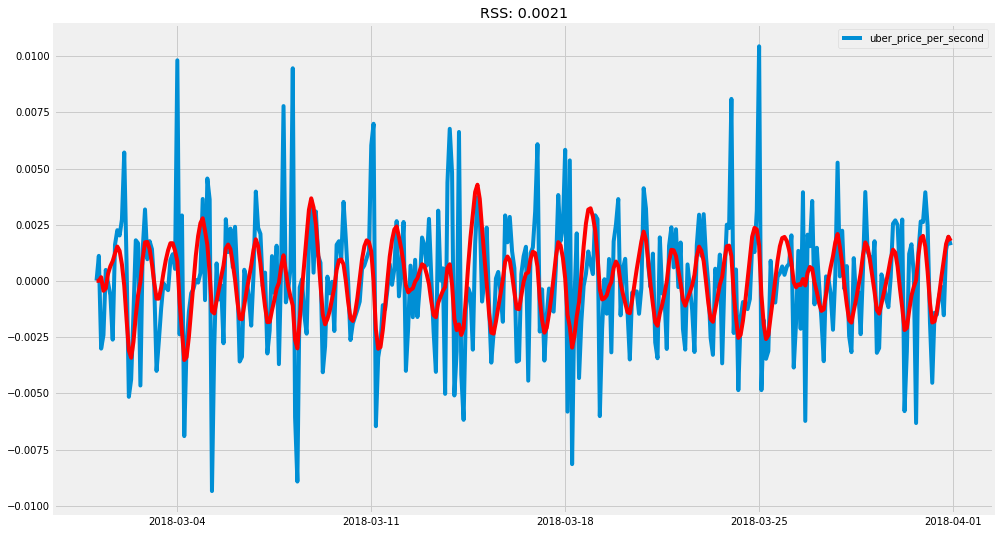

In [593]:
model = ARIMA(y_uber, order=(2, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(uber_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.legend(loc='best')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-uber_diff)**2))

RSS=0.0021, not bad

#### MA Model

Text(0.5,1,'RSS: 0.0029')

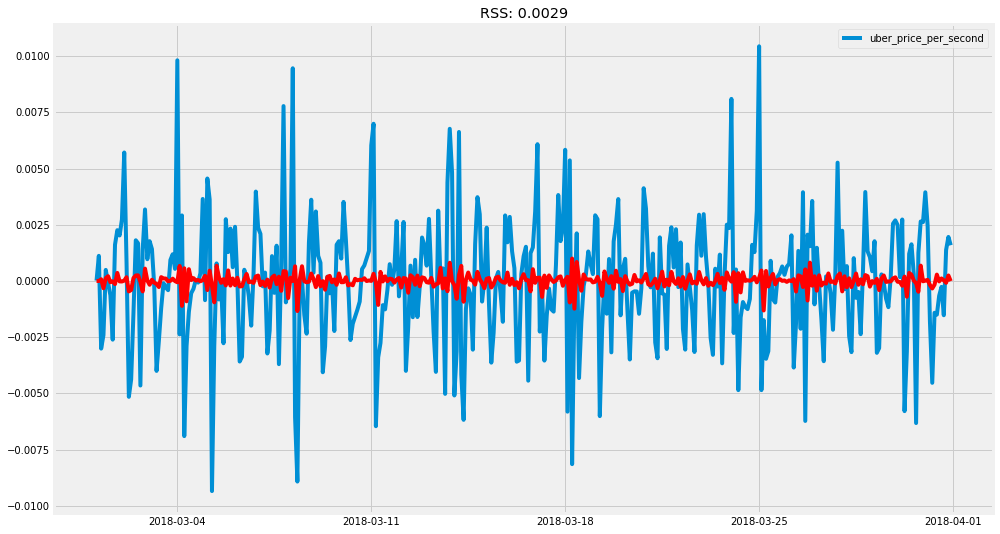

In [594]:
model = ARIMA(y_uber, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(uber_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.legend(loc='best')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-uber_diff)**2))

For the MA Model, the RSS is 0.0029, Larger than Combination Model

既然组合模型获得更好的结果，让我们将它倒回原始值，看看它如何执行。第一步是作为一个独立的序列，存储预测结果,观察它。

Since the combined model has better results, let's dump it back to the original value and see how it performs. The first step is to store the prediction as an independent sequence and observe it.

In [595]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date_time
2018-03-01 02:00:00    0.000003
2018-03-01 04:00:00    0.000004
2018-03-01 06:00:00    0.000164
2018-03-01 08:00:00   -0.000439
2018-03-01 10:00:00   -0.000334
Freq: 2H, dtype: float64


这是因为我们将第一小时取为滞后值，第一个小时前面没有可以减去的元素。
将差分转换为对数尺度的方法是这些差值连续地添加到基本值。一个简单的方法就是首先确定索引的累计总和,然后将其添加到基本值。累计总和可以在下面找到:

This is because we take the first hour as the lag value, and there is no element that can be subtracted before the first hour.
The method of converting the difference to a logarithmic scale is that these differences are continuously added to the base value. A simple way is to first determine the cumulative sum of the indexes and then add them to the base value. The cumulative sum can be found below:

In [596]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

date_time
2018-03-01 02:00:00    0.000003
2018-03-01 04:00:00    0.000007
2018-03-01 06:00:00    0.000171
2018-03-01 08:00:00   -0.000268
2018-03-01 10:00:00   -0.000602
Freq: 2H, dtype: float64


接下来我们将它们添加到基本值。为此我们将使用所有的值创建一个序列作为基本值，并添加差值。我们这样做：

Next we add them to the basic values.
For this we will use all the values to create a sequence as the base value and add the difference.

In [597]:
predictions_ARIMA_log = pd.Series(uber_diff.ix[0], index=uber_diff.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

date_time
2018-03-01 02:00:00    0.000016
2018-03-01 04:00:00    0.000020
2018-03-01 06:00:00    0.000184
2018-03-01 08:00:00   -0.000255
2018-03-01 10:00:00   -0.000589
Freq: 2H, dtype: float64

第一个元素是基本值本身，从基本值开始值累计添加。最后一步是将指数与原序列比较。

The first element is the basic value itself, which is added cumulatively from the basic value. The last step is to compare the index with the original sequence.

Text(0.5,1,'RMSE: 0.9857')

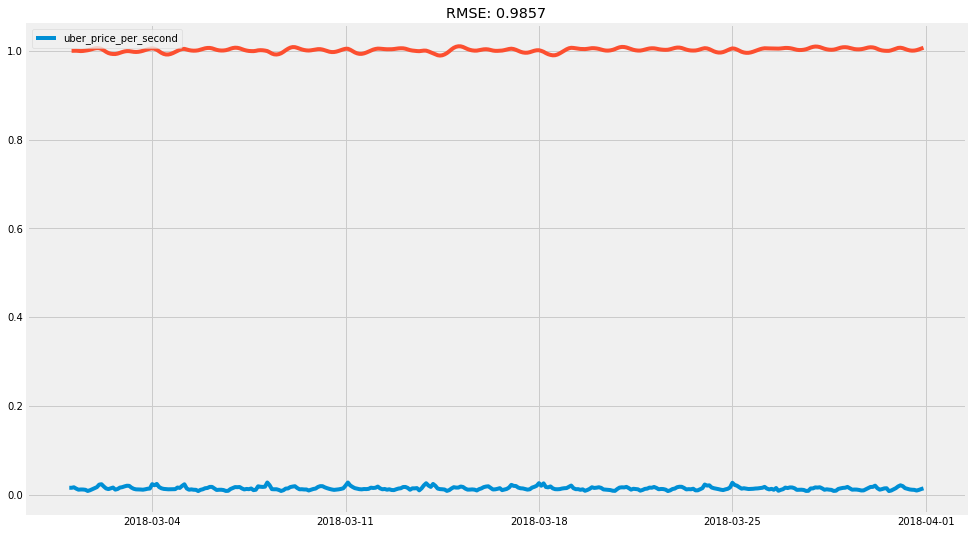

In [598]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(y_uber)
plt.plot(predictions_ARIMA)
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-y_uber)**2)/len(y_uber)))

#### Try MA Model

In [599]:
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)
print(predictions_MA_diff.head())

date_time
2018-03-01 02:00:00   -0.000004
2018-03-01 04:00:00   -0.000003
2018-03-01 06:00:00    0.000074
2018-03-01 08:00:00   -0.000327
2018-03-01 10:00:00    0.000121
Freq: 2H, dtype: float64


In [600]:
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()
print(predictions_MA_diff_cumsum.head())

date_time
2018-03-01 02:00:00   -0.000004
2018-03-01 04:00:00   -0.000007
2018-03-01 06:00:00    0.000067
2018-03-01 08:00:00   -0.000260
2018-03-01 10:00:00   -0.000140
Freq: 2H, dtype: float64


In [601]:
predictions_MA_log = pd.Series(uber_diff.ix[0], index=uber_diff.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum,fill_value=0)
predictions_MA_log.head()

date_time
2018-03-01 02:00:00    0.000009
2018-03-01 04:00:00    0.000006
2018-03-01 06:00:00    0.000080
2018-03-01 08:00:00   -0.000247
2018-03-01 10:00:00   -0.000127
Freq: 2H, dtype: float64

Text(0.5,1,'RMSE: 0.9831')

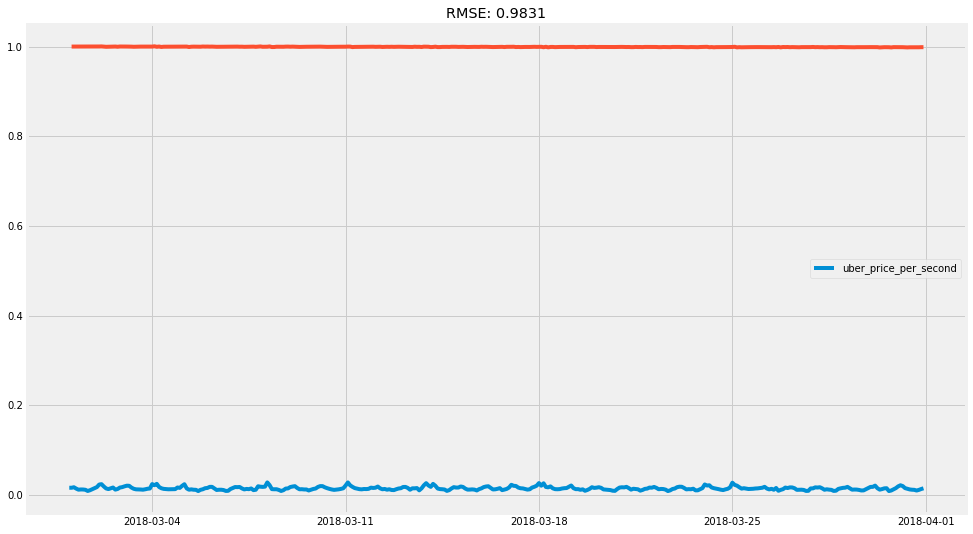

In [602]:
predictions_MA = np.exp(predictions_MA_log)
plt.plot(y_uber)
plt.plot(predictions_MA)
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_MA-y_uber)**2)/len(y_uber)))

The prediction is not good, so we will choose another prediction method

Source : https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/


The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT).